In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from itertools import product

### Part B
Variational Autoencoder (VAE) on sklearn digits

In [2]:
# Load sklearn digits
digits = load_digits()
X = digits.data.astype(np.float32) / 16.0 # scale to [0,1]
X_bin = (X > 0.5).astype(np.float32)
y = digits.target # only for inspection later

# Flatten to 64 dims
X_flat = X_bin.reshape(-1, 64)
data = torch.from_numpy(X_flat)

input_dim = X.shape[1] # 64 for 8x8 digits
device    = "cuda" if torch.cuda.is_available() else "cpu"

# Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_t = torch.from_numpy(X_train)
X_val_t   = torch.from_numpy(X_val)

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10, hidden_dims=(128, 128),
                 activation=nn.ReLU):
        super().__init__()
        self.latent_dim = latent_dim
        act = activation

        # Encoder
        enc_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            enc_layers.append(nn.Linear(prev_dim, h))
            if act is not None:
                enc_layers.append(act())
            prev_dim = h
        self.encoder_backbone = nn.Sequential(*enc_layers)
        self.fc_mu    = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

        # Decoder (mirror)
        dec_layers = []
        prev_dim = latent_dim
        for h in reversed(hidden_dims):
            dec_layers.append(nn.Linear(prev_dim, h))
            if act is not None:
                dec_layers.append(act())
            prev_dim = h
        dec_layers.append(nn.Linear(prev_dim, input_dim))  # no activation; MSE recon
        self.decoder = nn.Sequential(*dec_layers)

        self._init_xavier()

    def _init_xavier(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder_backbone(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [ ]:
def vae_loss(x, logits, mu, logvar, beta=1.0):
    # Convert logvar -> std to match JAX style
    # std = exp(0.5 * logvar)
    std = torch.exp(0.5 * logvar)

    # BCE-with-logits: matches optax.sigmoid_binary_cross_entropy
    recon_loss = torch.nn.functional.binary_cross_entropy_with_logits(
        logits, x, reduction='mean'
    )

    # KL divergence: 0.5 * sum(-log(std^2) - 1 + std^2 + mu^2)
    # matches JAX tutorial exactly
    kl = 0.5 * torch.mean(
        -torch.log(std**2 + 1e-8) - 1 + std**2 + mu**2
    )

    loss = recon_loss + beta * kl
    return loss, recon_loss, kl


In [5]:
def train_vae(X_train, X_val, vae_model, batch_size=128, lr=1e-3,
              n_epochs=100, beta=1.0, device="cpu", verbose=True):

    train_tensor = torch.tensor(X_train, dtype=torch.float32)
    val_tensor   = torch.tensor(X_val,   dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(train_tensor),
                              batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(val_tensor),
                              batch_size=batch_size, shuffle=False)

    vae_model.to(device)
    optimizer = torch.optim.AdamW(vae_model.parameters(), lr=lr, weight_decay=1e-5)

    history = {
        "train_total": [], "train_recon": [], "train_kl": [],
        "val_total":   [], "val_recon":   [], "val_kl":   [],
    }

    for epoch in tqdm(range(n_epochs), disable=not verbose):
        vae_model.train()
        tr_tot = tr_rec = tr_kl = 0.0
        n_batches = 0

        for (x_batch,) in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            # x_hat, mu, logvar = vae_model(x_batch)
            # loss, recon, kl = vae_loss(x_batch, x_hat, mu, logvar, beta=beta)
            x_hat_logits, mu, logvar = vae_model(x_batch)
            loss, recon, kl = vae_loss(x_batch, x_hat_logits, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            tr_tot += loss.item()
            tr_rec += recon.item()
            tr_kl  += kl.item()
            n_batches += 1

        history["train_total"].append(tr_tot / n_batches)
        history["train_recon"].append(tr_rec / n_batches)
        history["train_kl"].append(tr_kl / n_batches)

        # validation
        vae_model.eval()
        va_tot = va_rec = va_kl = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for (x_batch,) in val_loader:
                x_batch = x_batch.to(device)
                x_hat, mu, logvar = vae_model(x_batch)
                loss, recon, kl = vae_loss(x_batch, x_hat, mu, logvar, beta=beta)
                va_tot += loss.item()
                va_rec += recon.item()
                va_kl  += kl.item()
                n_val_batches += 1

        history["val_total"].append(va_tot / n_val_batches)
        history["val_recon"].append(va_rec / n_val_batches)
        history["val_kl"].append(va_kl / n_val_batches)

        if verbose and ((epoch + 1) % 50 == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch+1}/{n_epochs} | "
                  f"Train ELBO: {history['train_total'][-1]:.4f} | "
                  f"Val ELBO: {history['val_total'][-1]:.4f}")

    return vae_model, history


In [6]:
latent_grid  = [2, 4, 8, 10, 16]
hidden_grid  = [(64, 64), (128, 64)]
beta_grid    = [0.10, 0.50, 1.0, 2.0]

results = []

for latent_dim, hidden_dims, beta in product(latent_grid, hidden_grid, beta_grid):
    print(f"\n=== Training VAE: latent_dim={latent_dim}, hidden_dims={hidden_dims}, beta={beta} ===")
    vae = VAE(input_dim=input_dim, latent_dim=latent_dim,
              hidden_dims=hidden_dims, activation=nn.ReLU)
    vae, hist = train_vae(
        X_train, X_val, vae,
        batch_size=256, lr=1e-3,
        n_epochs=100, beta=beta,
        device=device, verbose=False
    )

    best_val_elbo = min(hist["val_total"]) 
    results.append({
        "latent_dim": latent_dim,
        "hidden_dims": hidden_dims,
        "beta": beta,
        "best_val_elbo": best_val_elbo
    })
    print(f"Best val ELBO: {best_val_elbo:.4f}")

results_df = pd.DataFrame(results).sort_values("best_val_elbo")
results_df



=== Training VAE: latent_dim=2, hidden_dims=(64, 64), beta=0.1 ===
Best val ELBO: 0.4241

=== Training VAE: latent_dim=2, hidden_dims=(64, 64), beta=0.5 ===
Best val ELBO: 0.4243

=== Training VAE: latent_dim=2, hidden_dims=(64, 64), beta=1.0 ===
Best val ELBO: 0.4242

=== Training VAE: latent_dim=2, hidden_dims=(64, 64), beta=2.0 ===
Best val ELBO: 0.4246

=== Training VAE: latent_dim=2, hidden_dims=(128, 64), beta=0.1 ===
Best val ELBO: 0.4241

=== Training VAE: latent_dim=2, hidden_dims=(128, 64), beta=0.5 ===
Best val ELBO: 0.4243

=== Training VAE: latent_dim=2, hidden_dims=(128, 64), beta=1.0 ===
Best val ELBO: 0.4243

=== Training VAE: latent_dim=2, hidden_dims=(128, 64), beta=2.0 ===
Best val ELBO: 0.4244

=== Training VAE: latent_dim=4, hidden_dims=(64, 64), beta=0.1 ===
Best val ELBO: 0.4076

=== Training VAE: latent_dim=4, hidden_dims=(64, 64), beta=0.5 ===
Best val ELBO: 0.4244

=== Training VAE: latent_dim=4, hidden_dims=(64, 64), beta=1.0 ===
Best val ELBO: 0.4249

=== T

,latent_dim,hidden_dims,beta,best_val_elbo
36,16,"(128, 64)",0.1,0.343635
32,16,"(64, 64)",0.1,0.349428
28,10,"(128, 64)",0.1,0.363785
24,10,"(64, 64)",0.1,0.369672
20,8,"(128, 64)",0.1,0.370578
16,8,"(64, 64)",0.1,0.377970
8,4,"(64, 64)",0.1,0.407643
12,4,"(128, 64)",0.1,0.407827
15,4,"(128, 64)",2.0,0.424026
0,2,"(64, 64)",0.1,0.424069


In [7]:
best = results_df.iloc[0]
best

latent_dim              16
hidden_dims      (128, 64)
beta                   0.1
best_val_elbo     0.343635
Name: 36, dtype: object

In [8]:
best_latent = int(best["latent_dim"])
best_hidden = best["hidden_dims"]
best_beta   = float(best["beta"])

print("Best config:", best_latent, best_hidden, best_beta)

# Retrain on full data (train+val merged) to use all samples
X_full = np.vstack([X_train, X_val])

best_vae = VAE(input_dim=input_dim, latent_dim=best_latent,
               hidden_dims=best_hidden, activation=nn.ReLU)

best_vae, best_hist = train_vae(
    X_full, X_val=None if False else X_val,
    vae_model=best_vae,
    batch_size=256, lr=1e-3,
    n_epochs=500, beta=best_beta,
    device=device, verbose=True
)


Best config: 16 (128, 64) 0.1


 12%|█▏        | 59/500 [00:00<00:03, 114.40it/s]

Epoch 50/500 | Train ELBO: 0.3720 | Val ELBO: 0.3680


 24%|██▎       | 118/500 [00:01<00:03, 111.77it/s]

Epoch 100/500 | Train ELBO: 0.3485 | Val ELBO: 0.3506


 33%|███▎      | 166/500 [00:01<00:03, 102.13it/s]

Epoch 150/500 | Train ELBO: 0.3404 | Val ELBO: 0.3398


 42%|████▏     | 210/500 [00:01<00:02, 98.41it/s] 

Epoch 200/500 | Train ELBO: 0.3386 | Val ELBO: 0.3356


 54%|█████▍    | 270/500 [00:02<00:02, 114.63it/s]

Epoch 250/500 | Train ELBO: 0.3353 | Val ELBO: 0.3316


 64%|██████▎   | 318/500 [00:02<00:01, 111.18it/s]

Epoch 300/500 | Train ELBO: 0.3298 | Val ELBO: 0.3314


 73%|███████▎  | 365/500 [00:03<00:01, 109.46it/s]

Epoch 350/500 | Train ELBO: 0.3364 | Val ELBO: 0.3279


 82%|████████▏ | 412/500 [00:03<00:00, 107.59it/s]

Epoch 400/500 | Train ELBO: 0.3289 | Val ELBO: 0.3266


 94%|█████████▍| 472/500 [00:04<00:00, 113.83it/s]

Epoch 450/500 | Train ELBO: 0.3268 | Val ELBO: 0.3248


100%|██████████| 500/500 [00:04<00:00, 107.50it/s]

Epoch 500/500 | Train ELBO: 0.3267 | Val ELBO: 0.3261


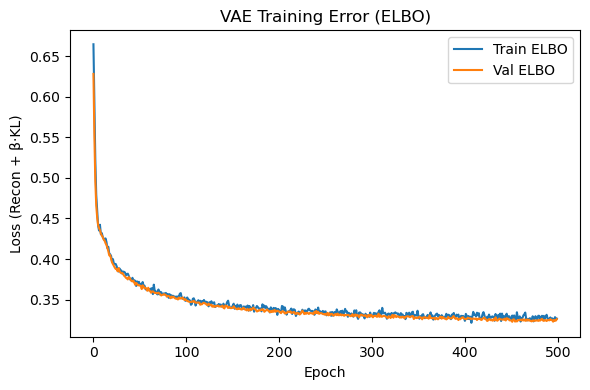

In [9]:
plt.figure(figsize=(6,4))
plt.plot(best_hist["train_total"], label="Train ELBO")
plt.plot(best_hist["val_total"],   label="Val ELBO")
plt.xlabel("Epoch")
plt.ylabel("Loss (Recon + β·KL)")
plt.title("VAE Training Error (ELBO)")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
best_vae.eval()
with torch.no_grad():
    X_all_t = torch.from_numpy(X).to(device)
    mu_all, logvar_all = best_vae.encode(X_all_t)
    z_all = mu_all.cpu().numpy()

print(z_all.shape)


(1797, 16)


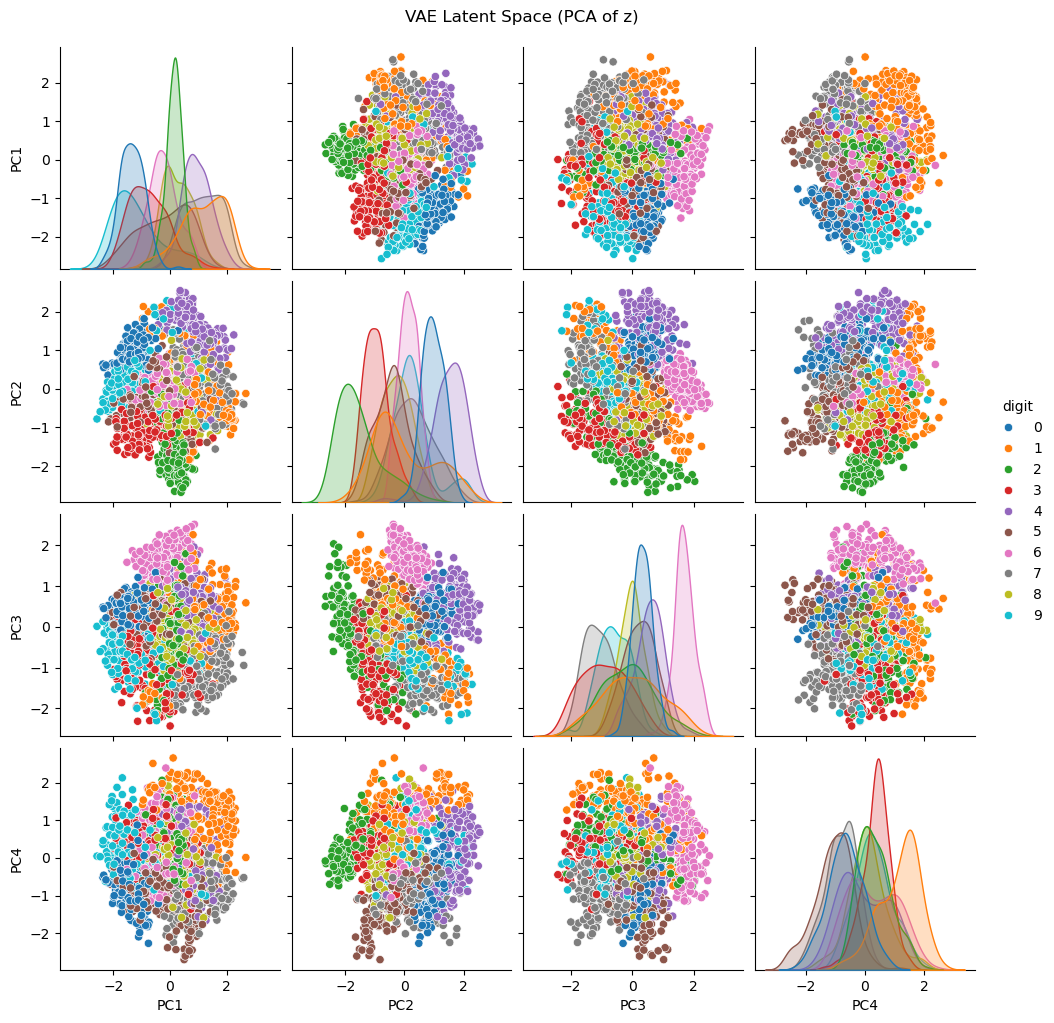

In [11]:
pca_latent = PCA(n_components=4)
Z_pca = pca_latent.fit_transform(z_all)

latent_df = pd.DataFrame(Z_pca[:, :4], columns=[f"PC{i+1}" for i in range(4)])
latent_df["digit"] = y

sns.pairplot(latent_df, hue="digit", palette="tab10")
plt.suptitle("VAE Latent Space (PCA of z)", y=1.02)
plt.show()


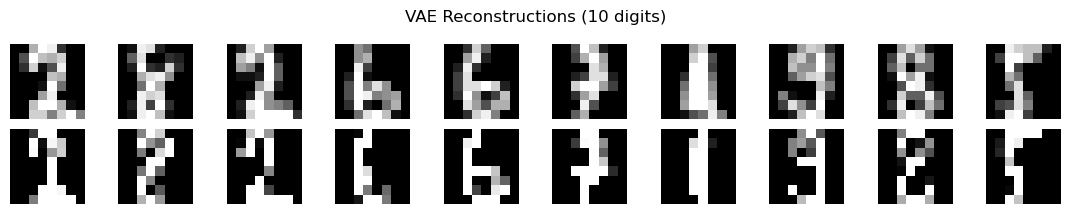

In [12]:
def show_reconstructions(model, X_data, n=20, seed=0, title="VAE reconstructions"):
    model.eval()
    rng = np.random.RandomState(seed)
    idx = rng.choice(X_data.shape[0], size=n, replace=False)
    x = torch.from_numpy(X_data[idx]).to(device)
    with torch.no_grad():
        x_hat, _, _ = model(x)

    x = x.cpu().numpy()
    x_hat = x_hat.cpu().numpy()

    H = W = 8
    fig, axes = plt.subplots(2, n, figsize=(1.1*n, 2.2))
    for j in range(n):
        axes[0, j].imshow(x[j].reshape(H, W), cmap="gray")
        axes[0, j].axis("off")
        axes[1, j].imshow(np.clip(x_hat[j].reshape(H, W), 0, 1), cmap="gray")
        axes[1, j].axis("off")
    axes[0, 0].set_ylabel("Original", fontsize=8)
    axes[1, 0].set_ylabel("Recon", fontsize=8)
    fig.suptitle(title, y=0.95)
    plt.tight_layout()
    plt.show()

show_reconstructions(best_vae, X, n=10, title="VAE Reconstructions (10 digits)")


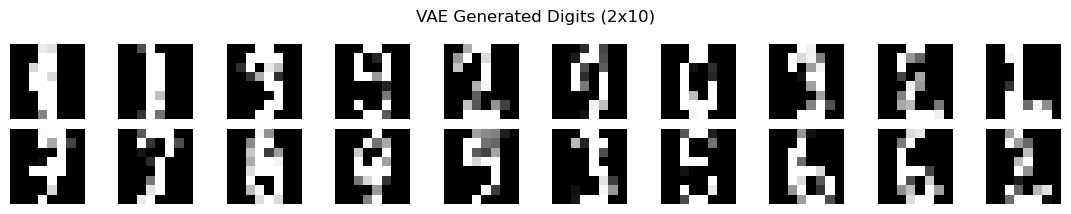

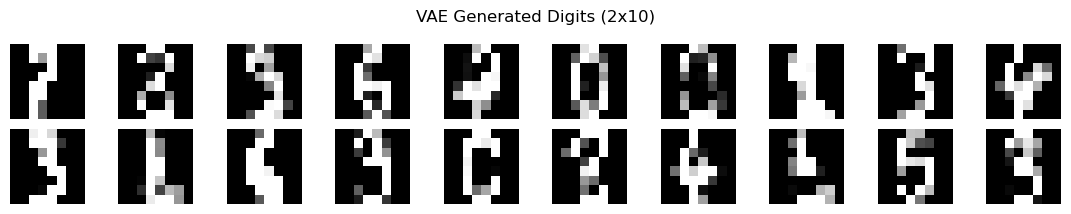

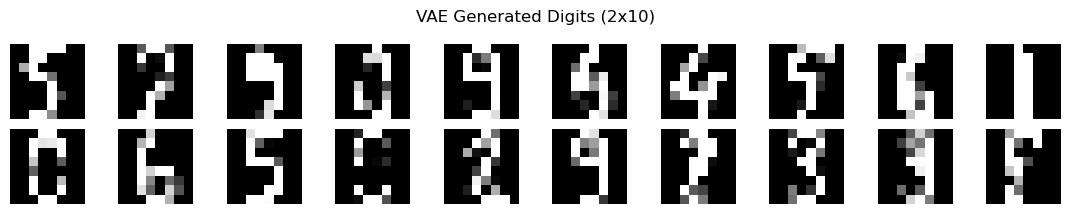

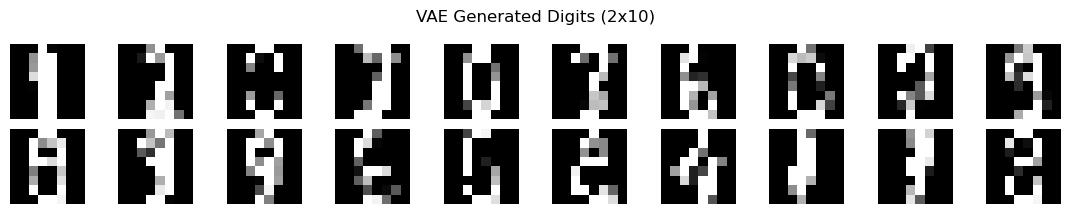

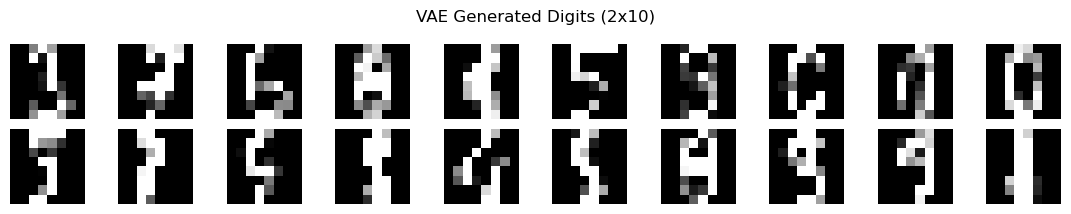

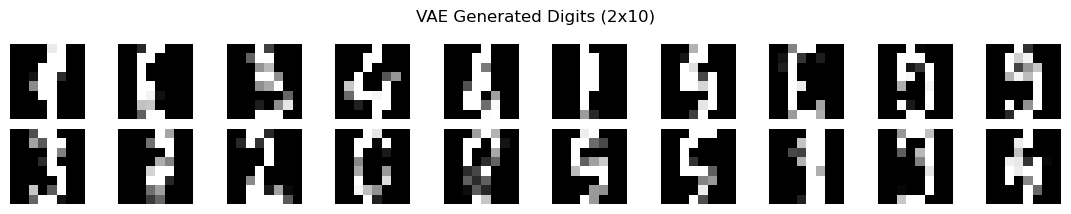

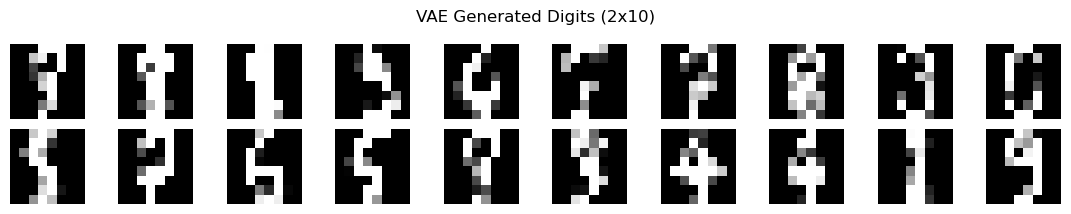

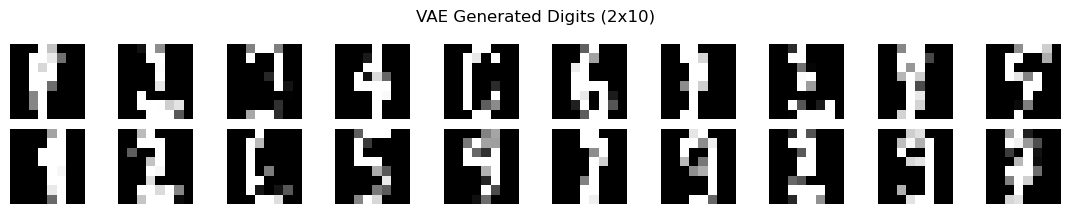

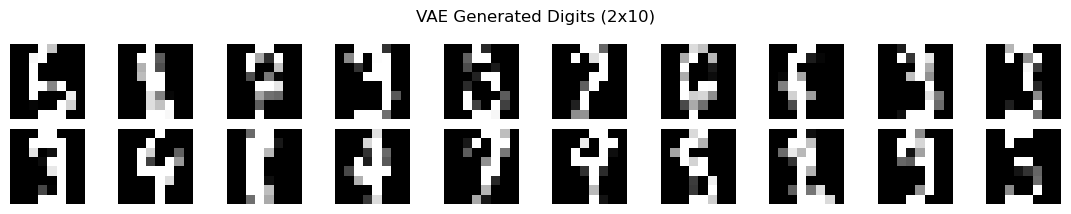

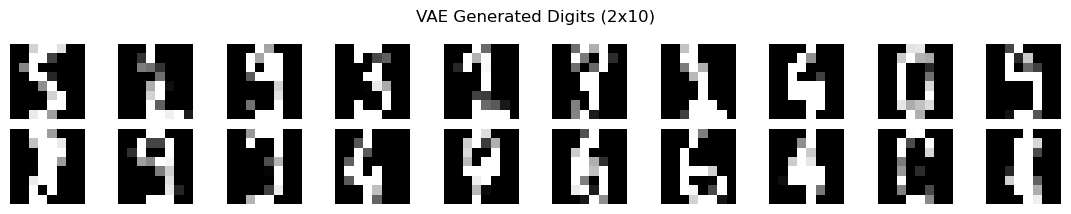

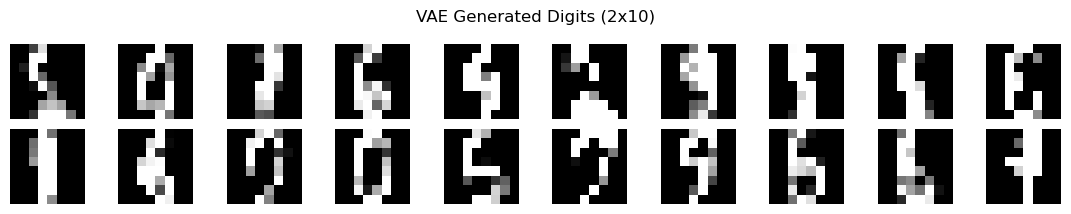

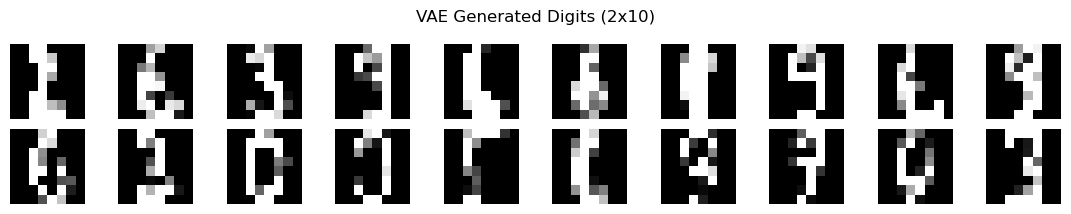

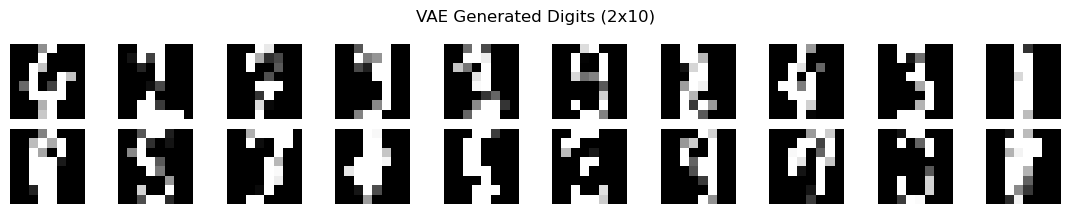

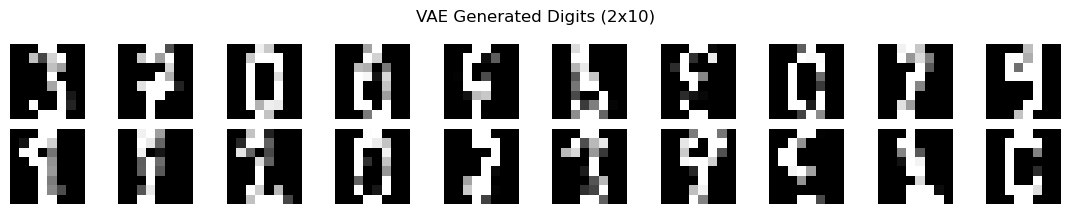

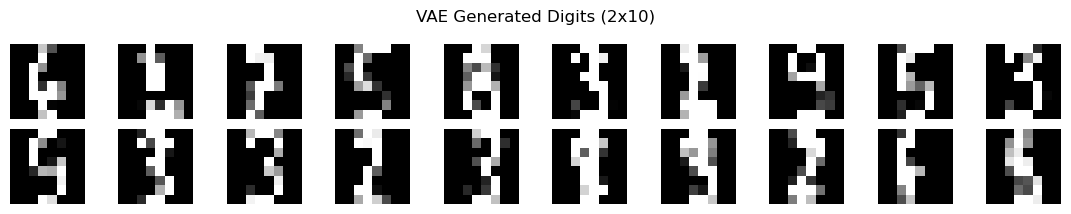

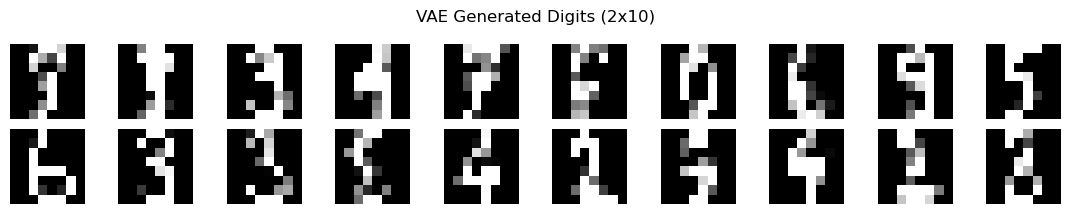

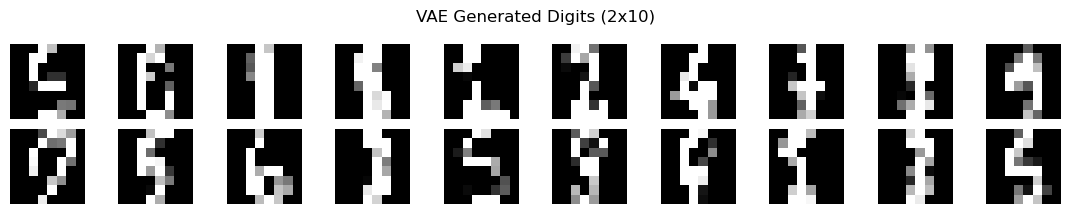

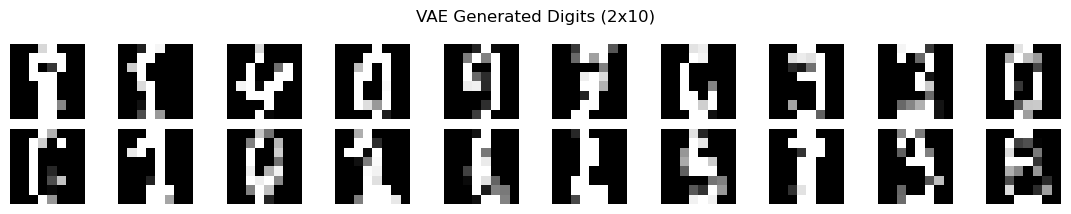

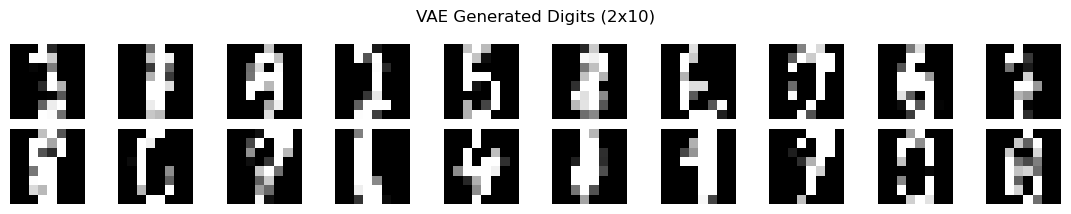

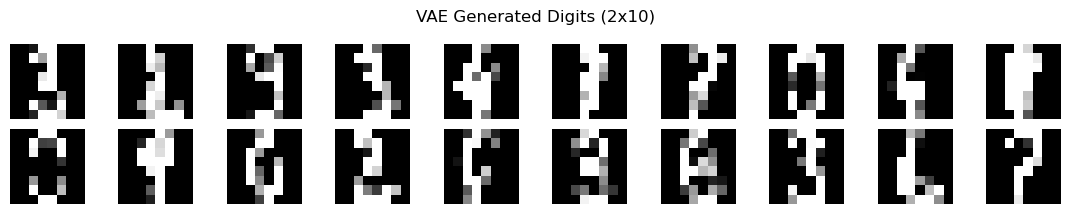

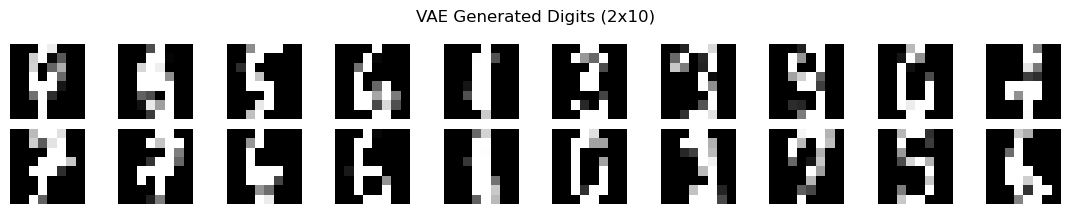

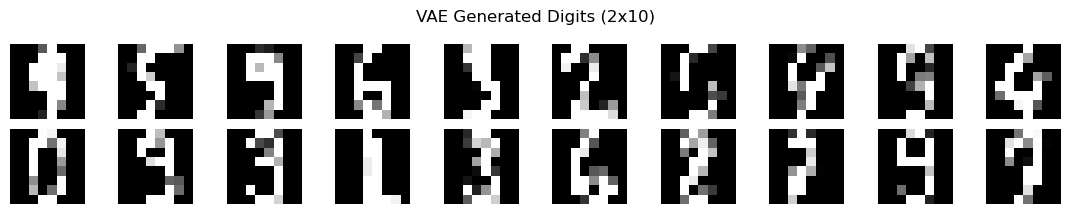

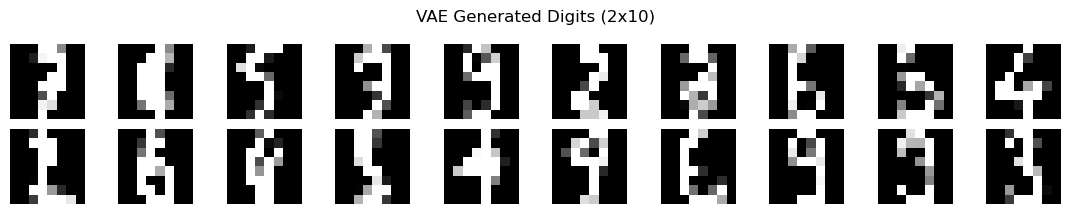

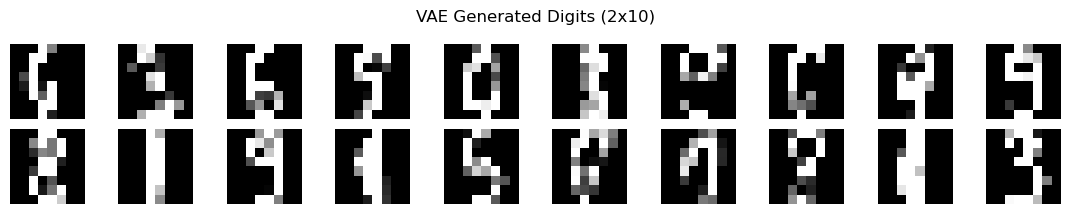

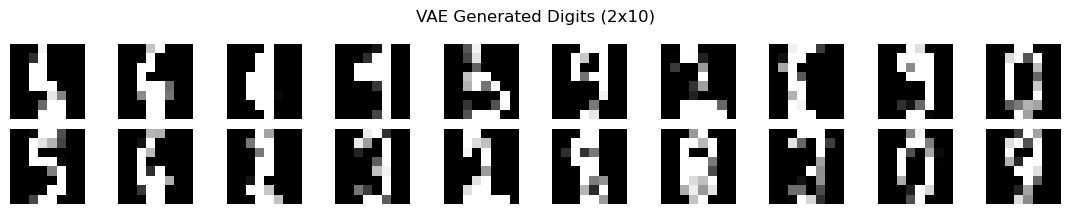

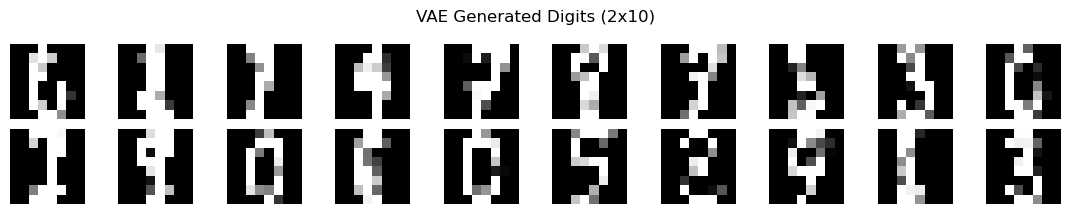

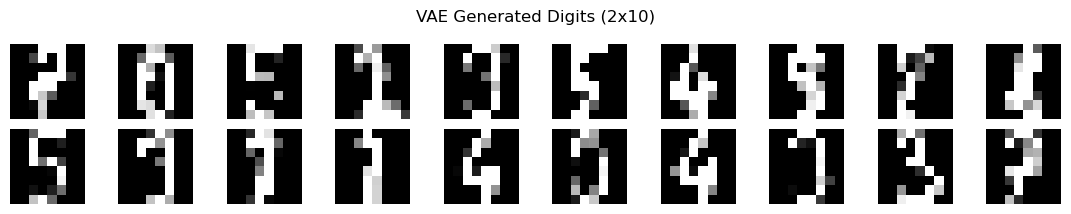

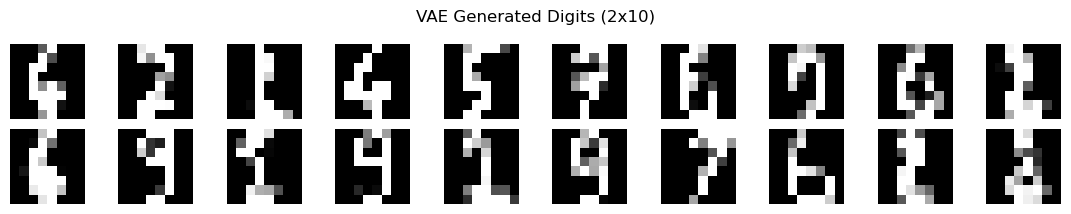

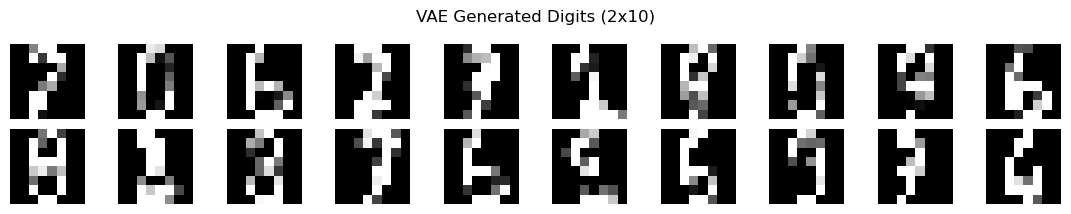

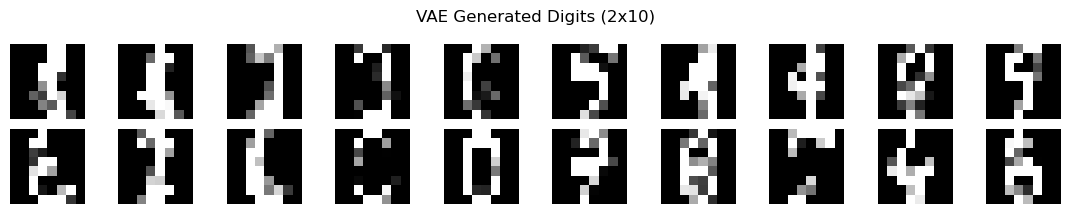

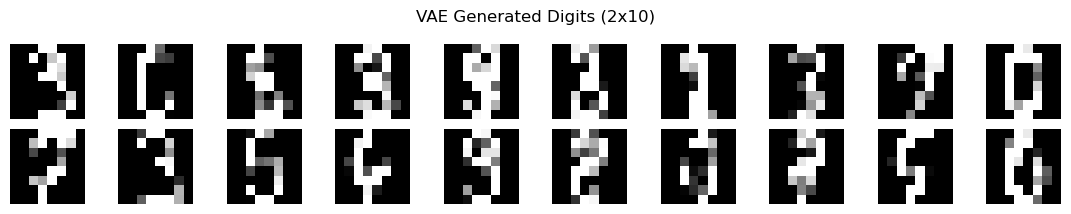

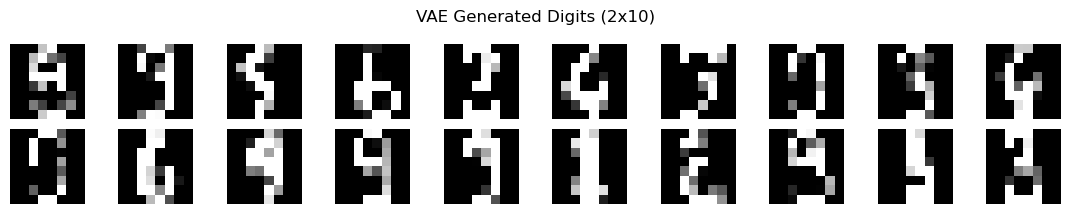

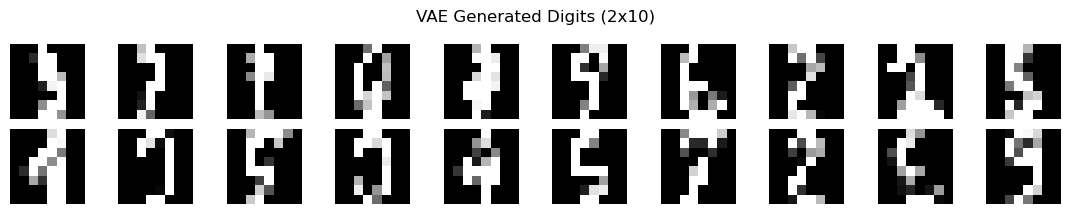

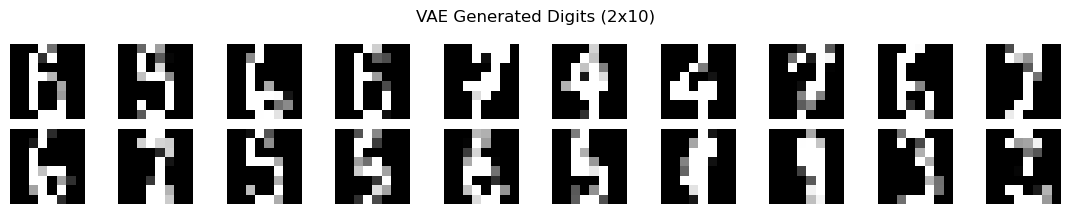

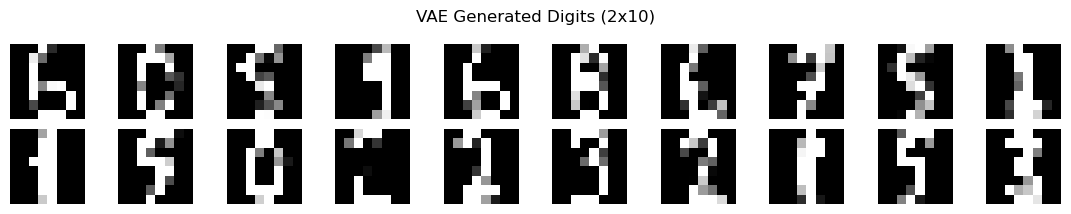

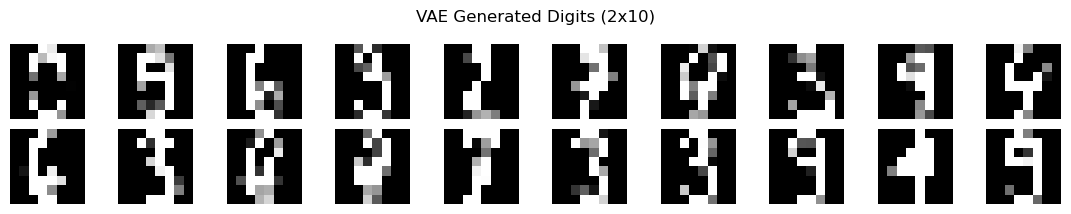

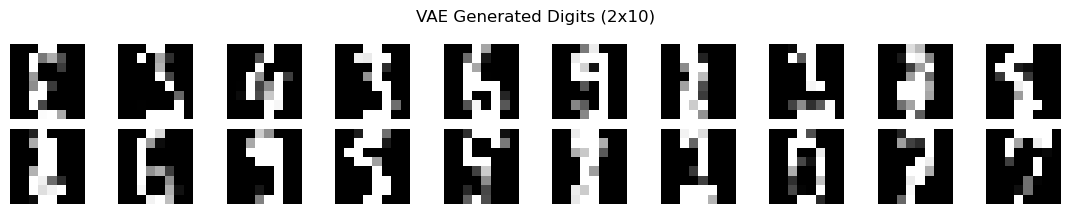

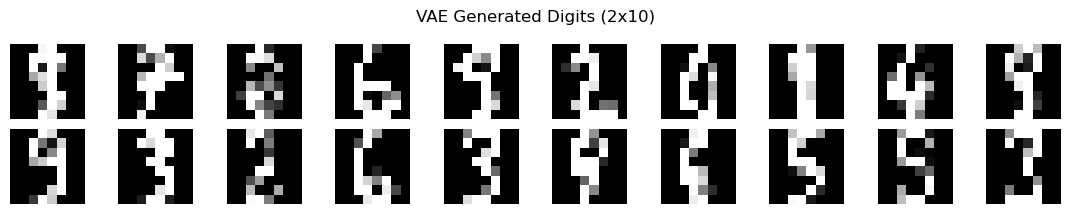

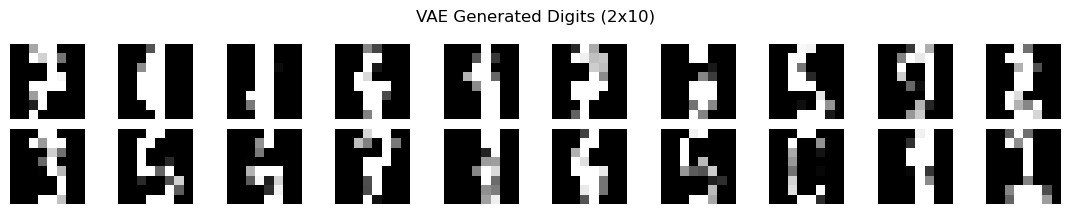

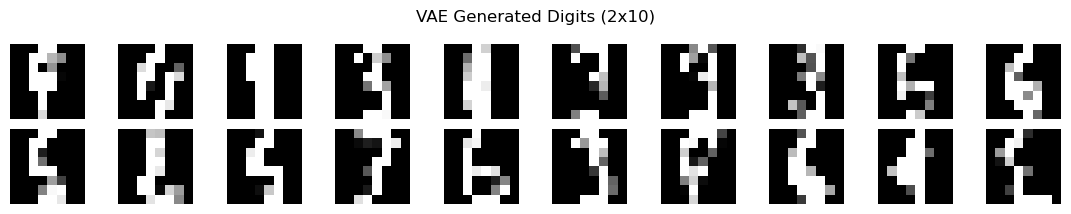

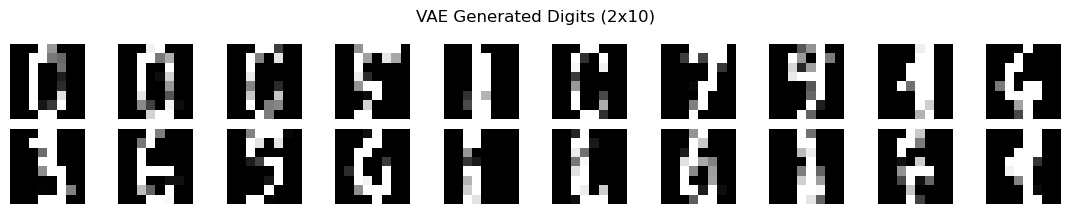

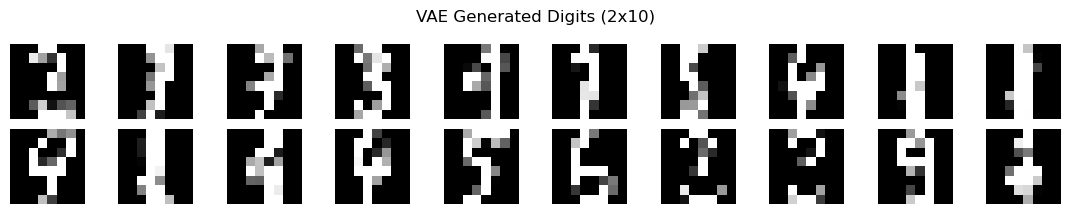

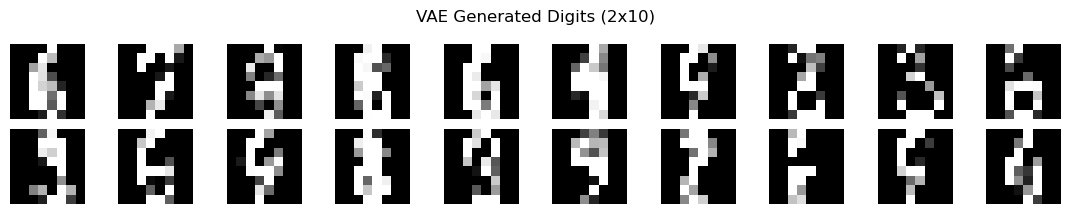

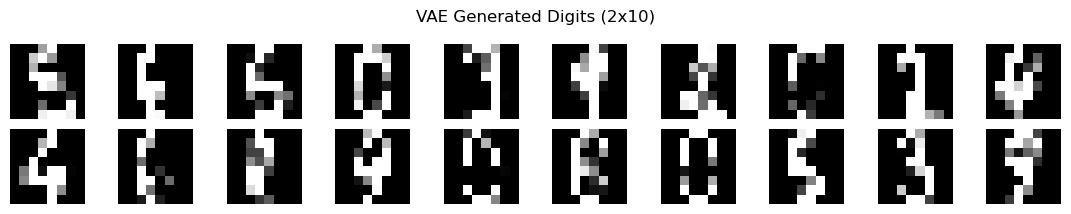

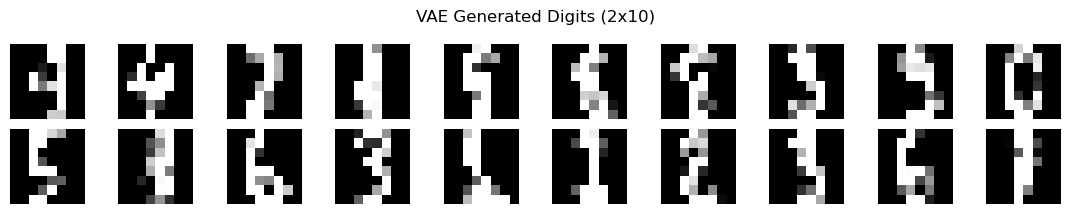

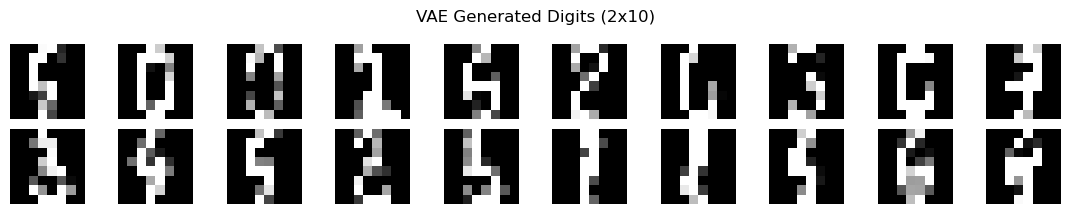

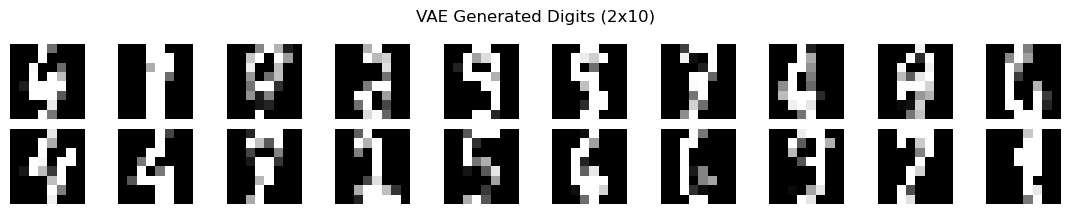

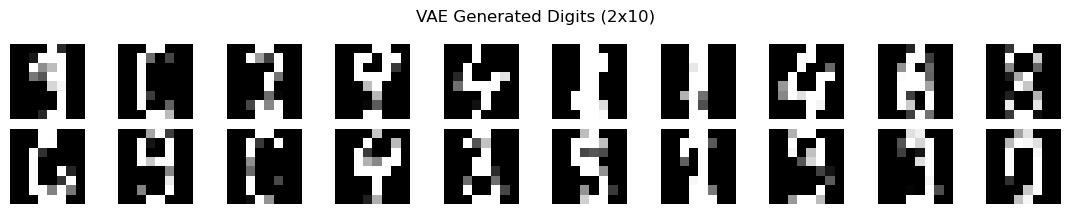

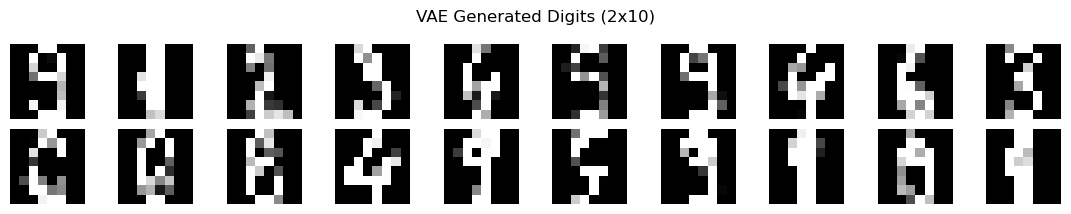

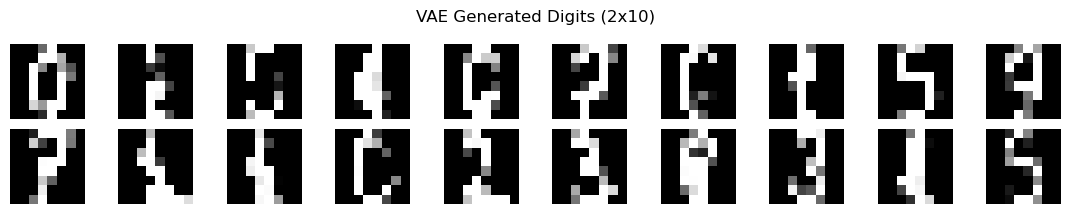

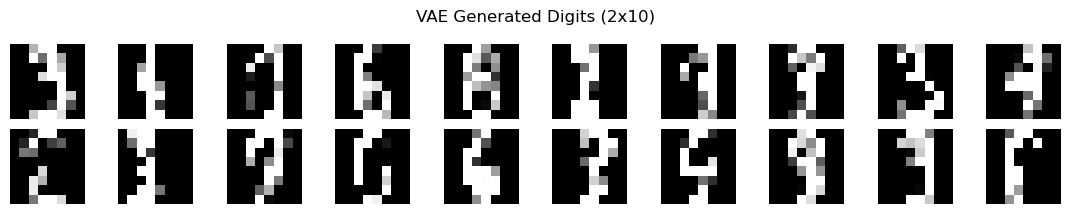

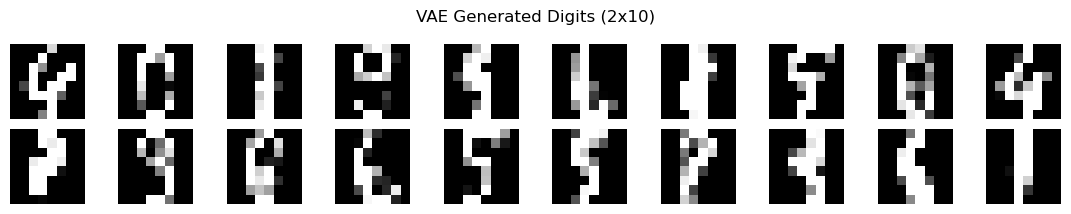

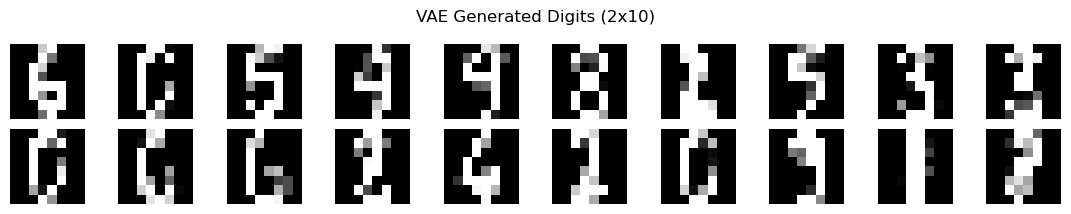

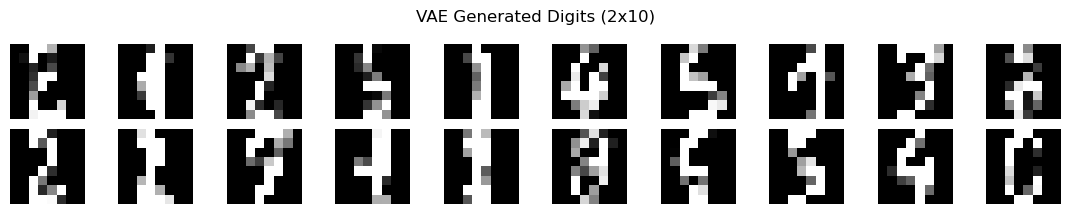

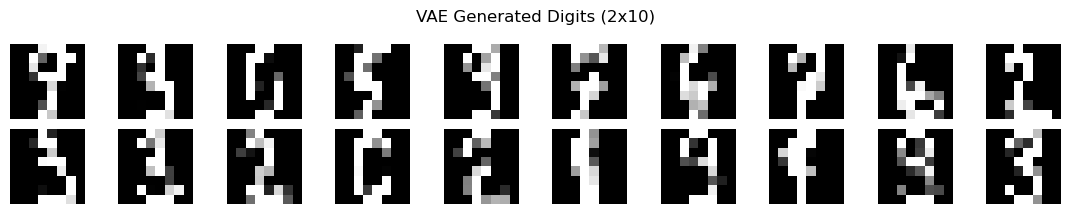

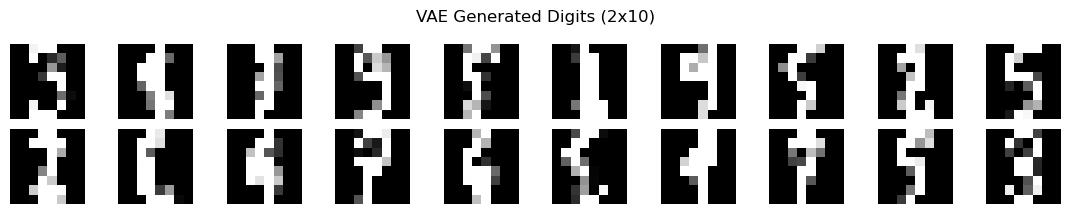

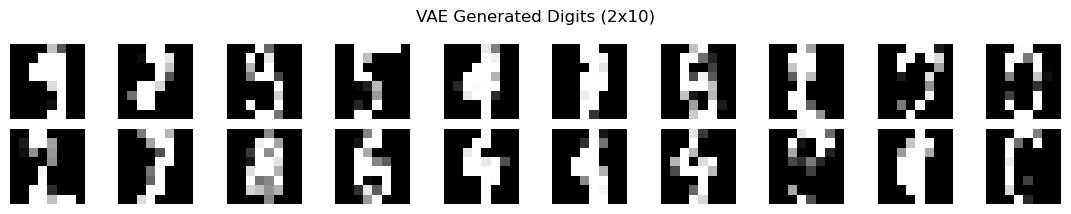

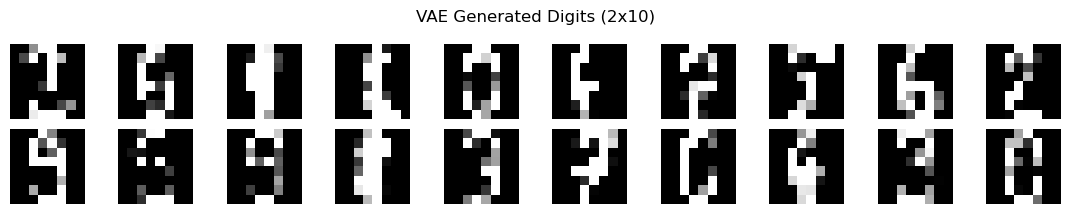

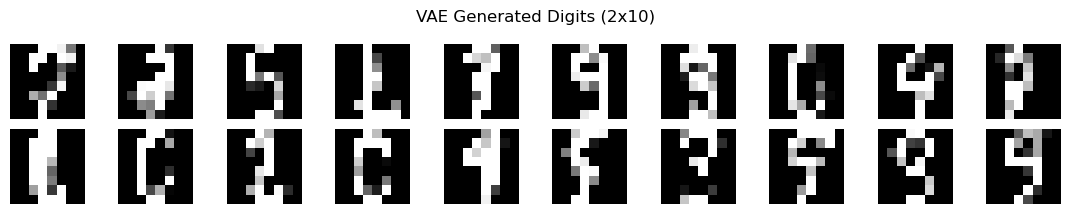

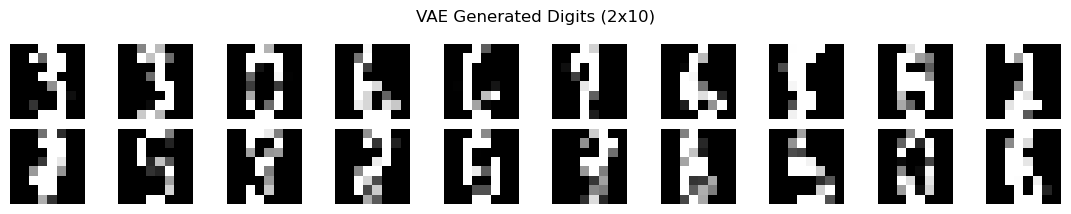

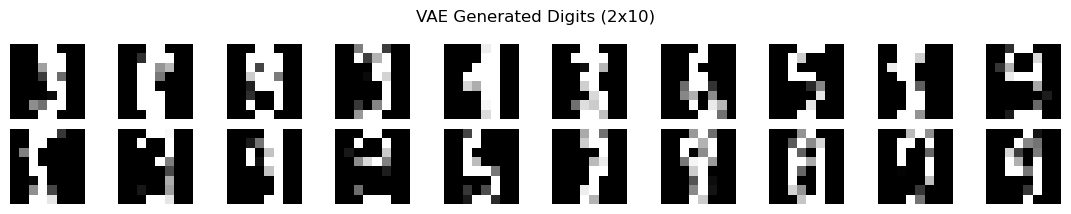

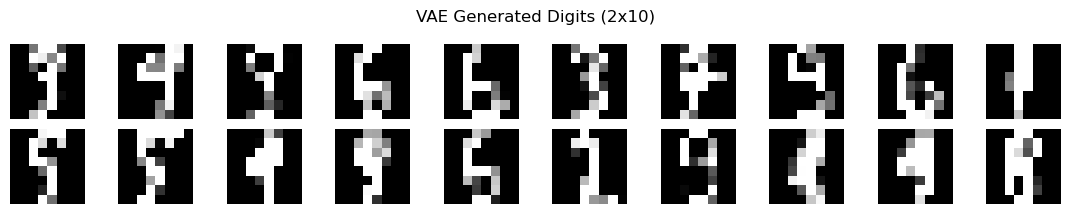

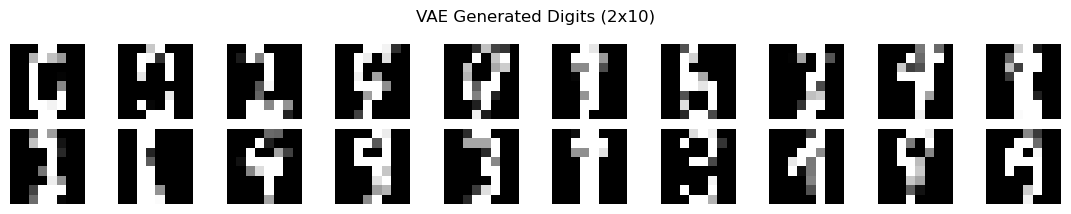

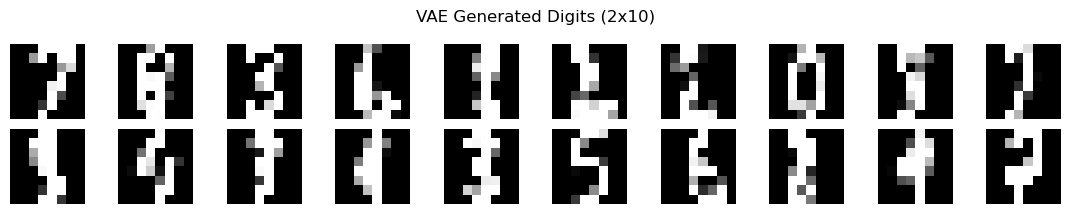

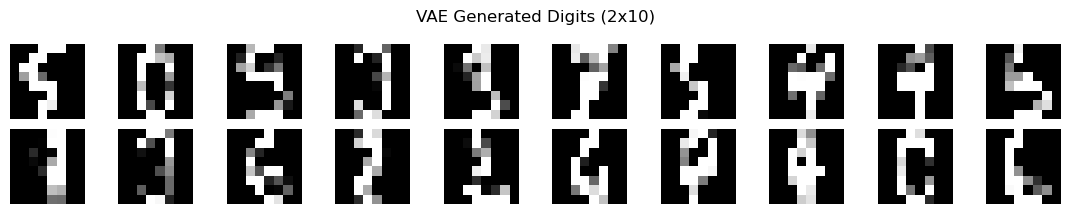

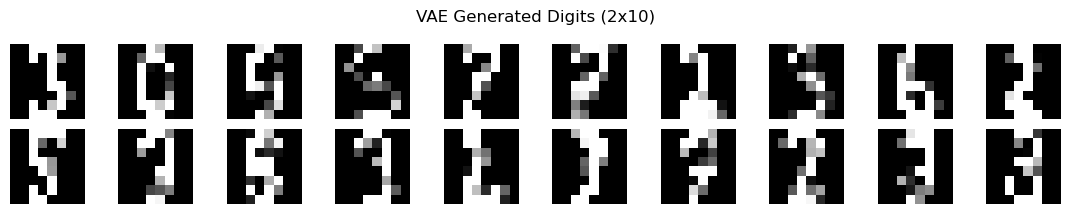

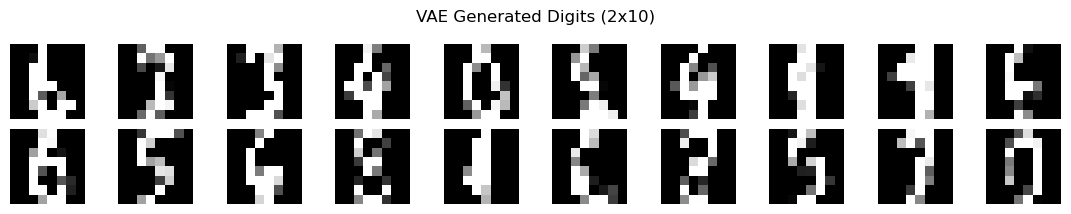

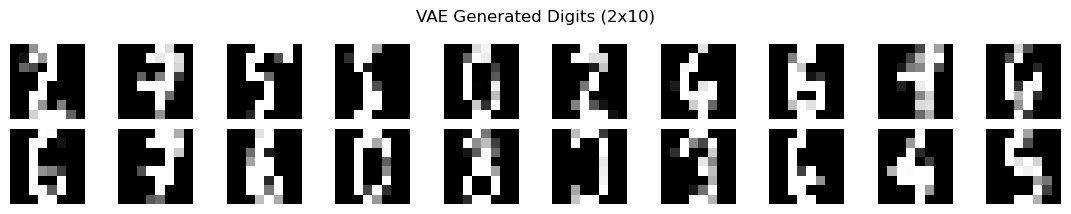

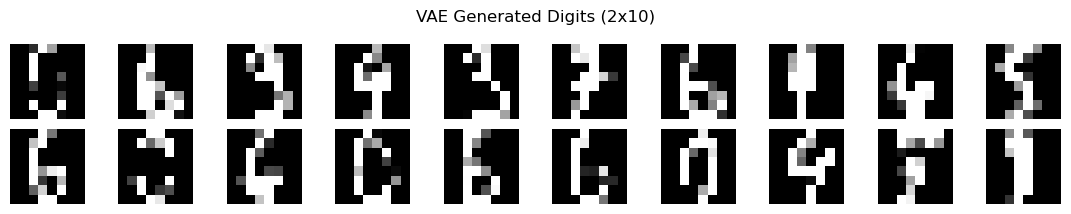

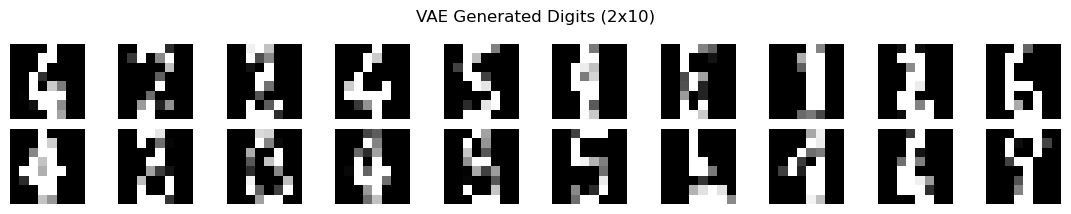

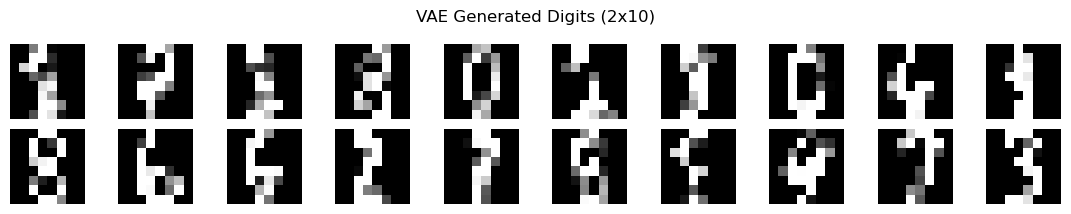

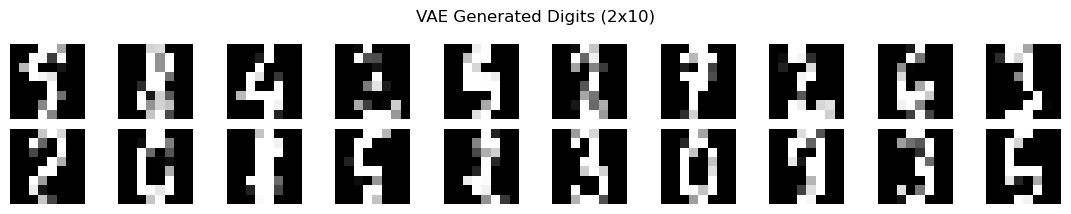

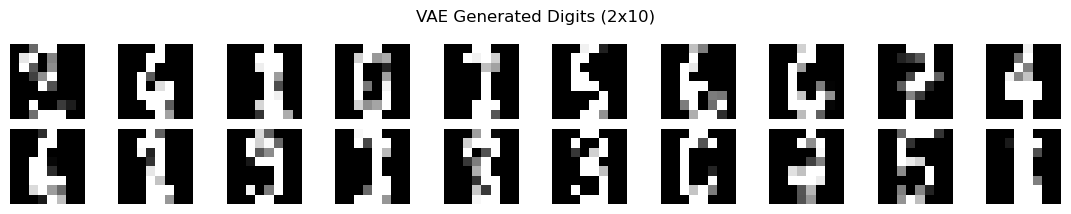

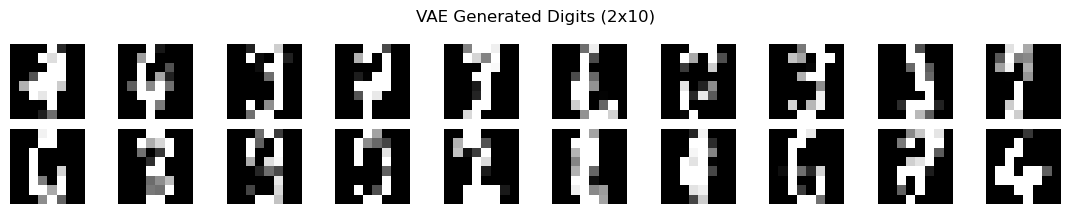

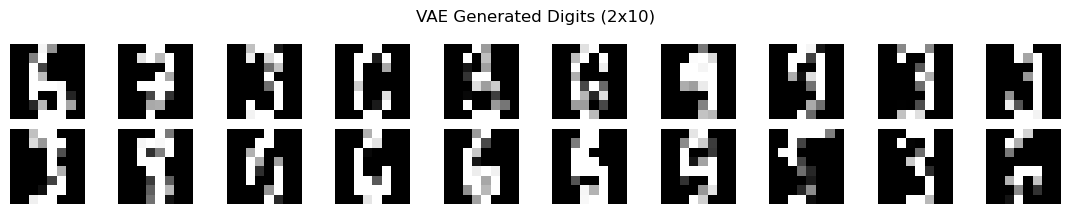

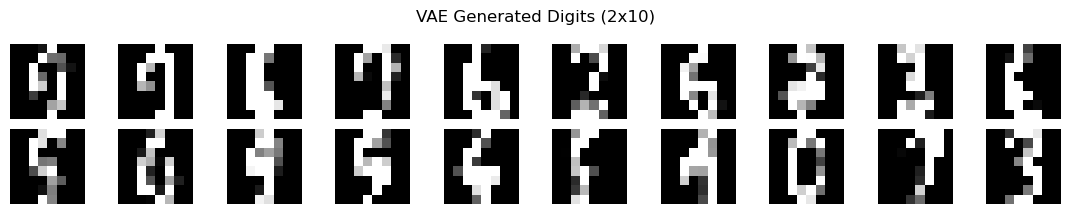

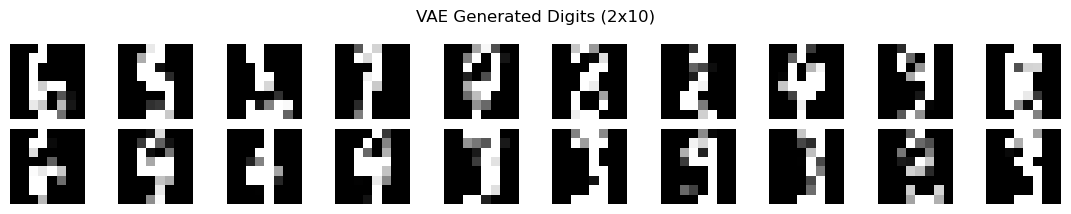

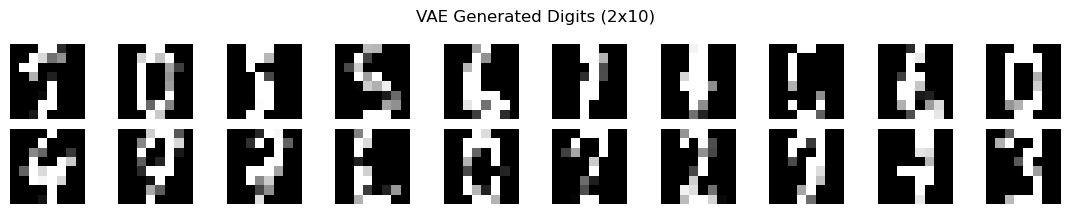

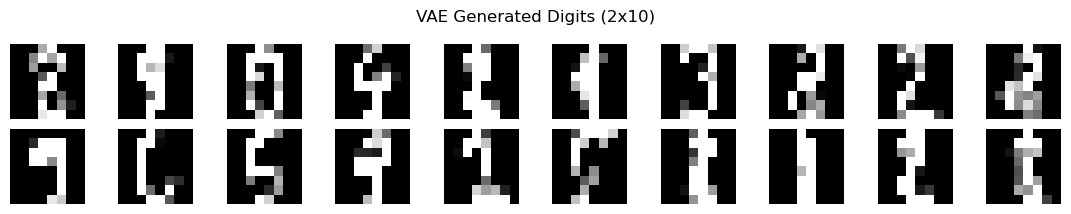

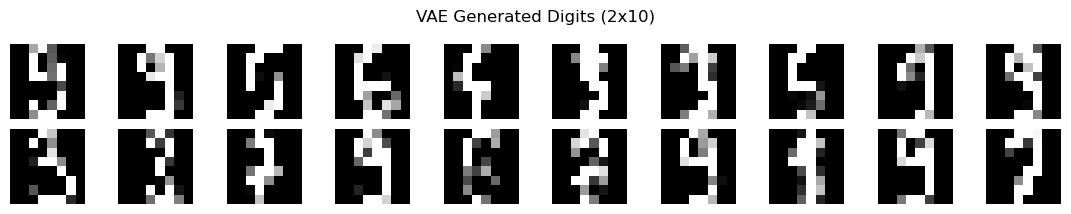

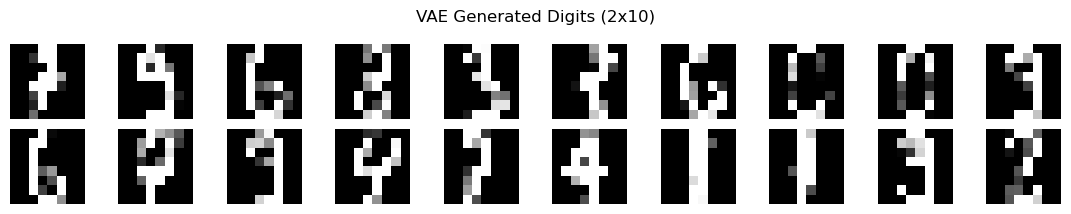

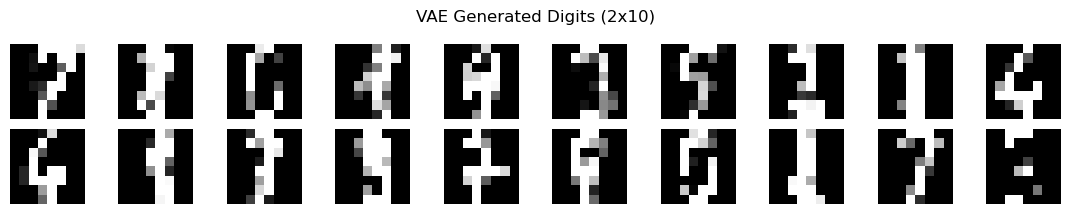

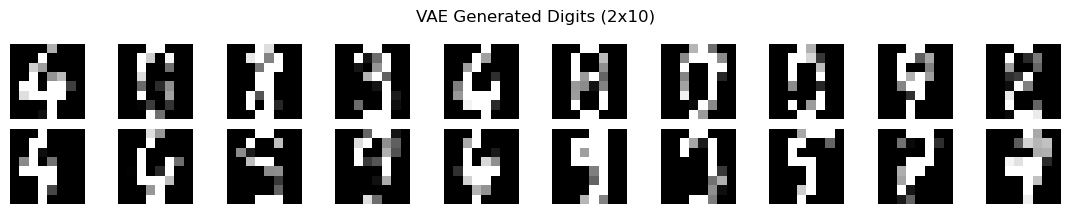

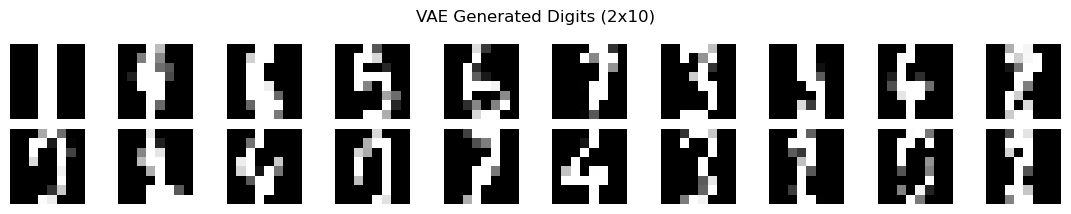

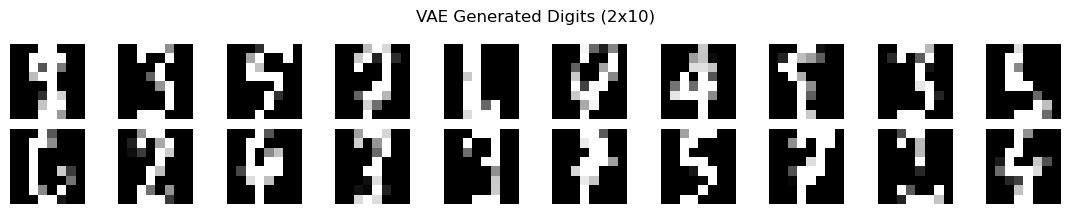

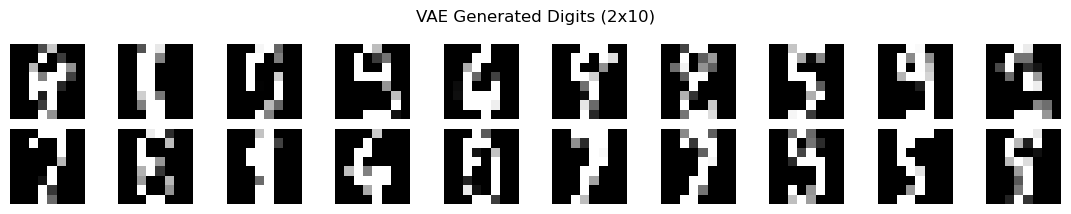

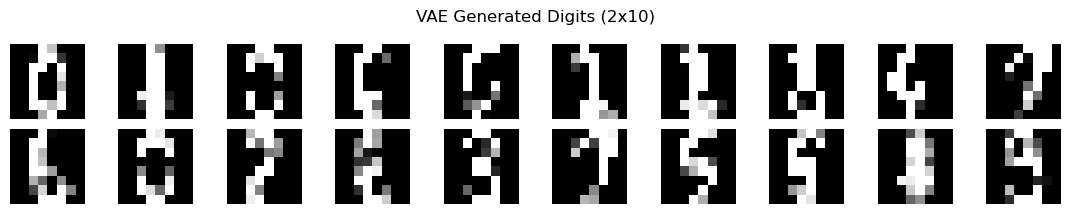

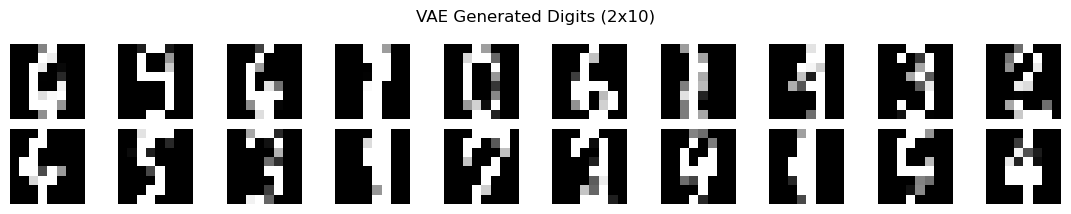

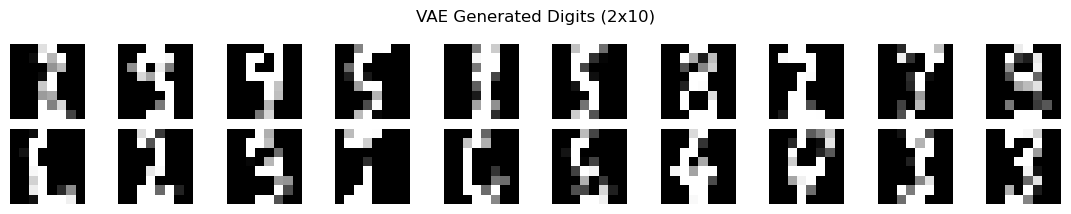

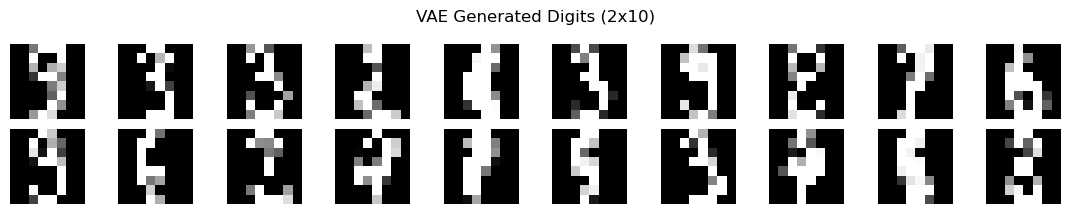

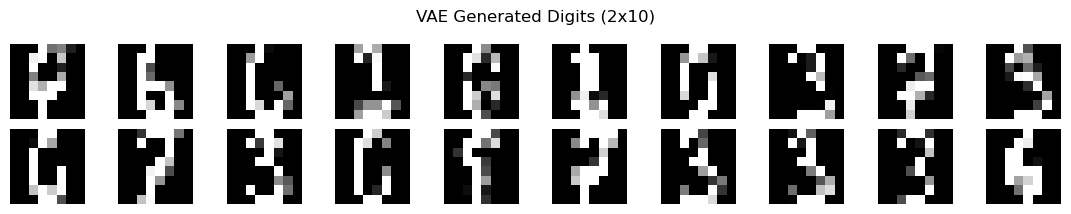

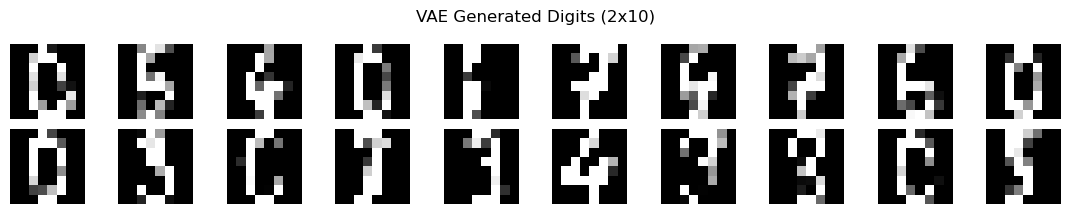

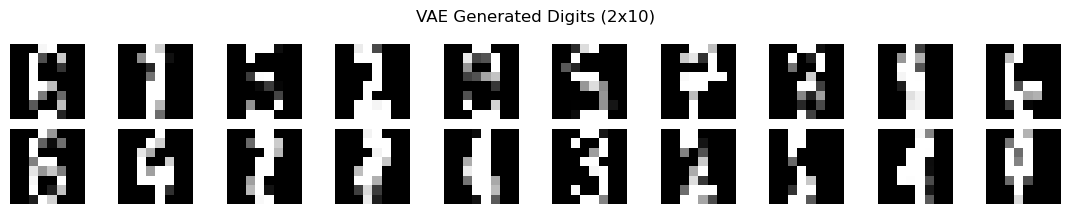

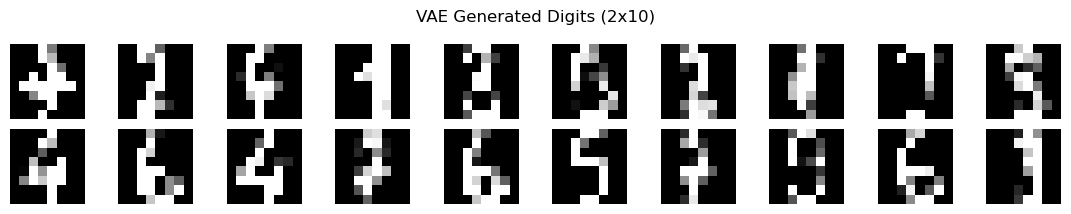

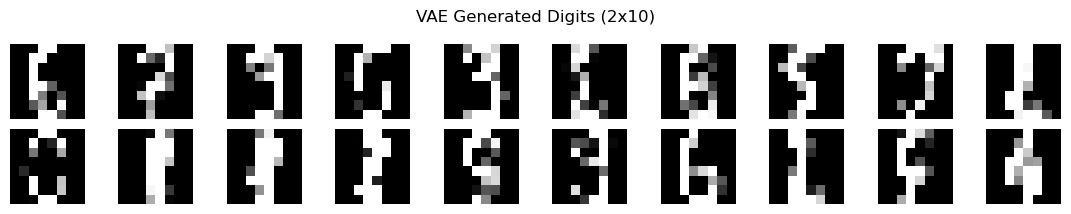

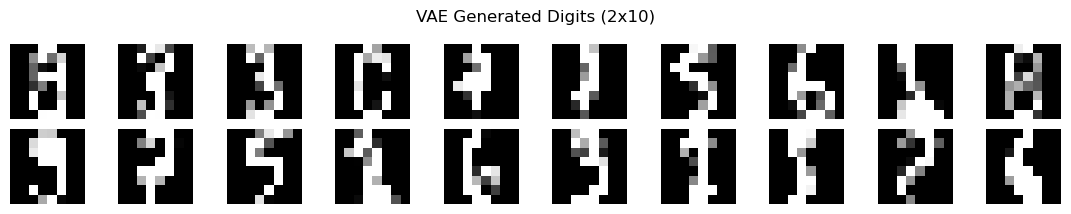

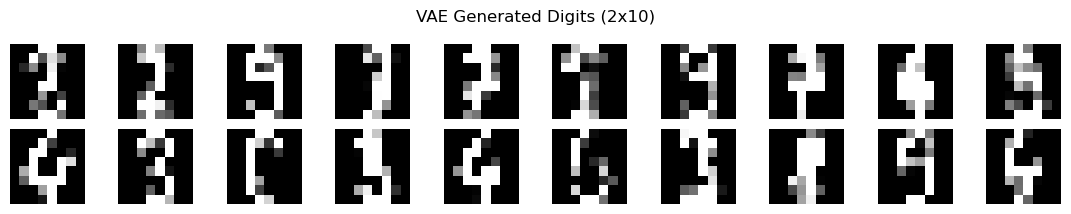

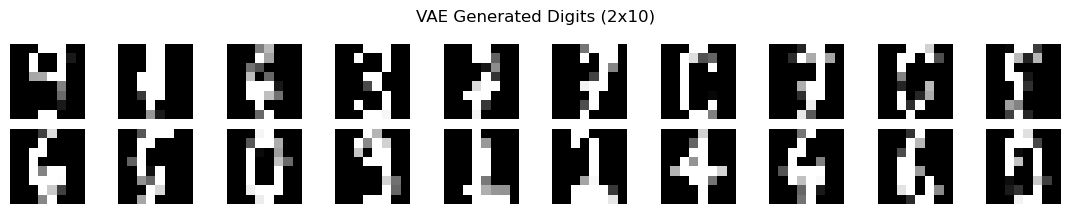

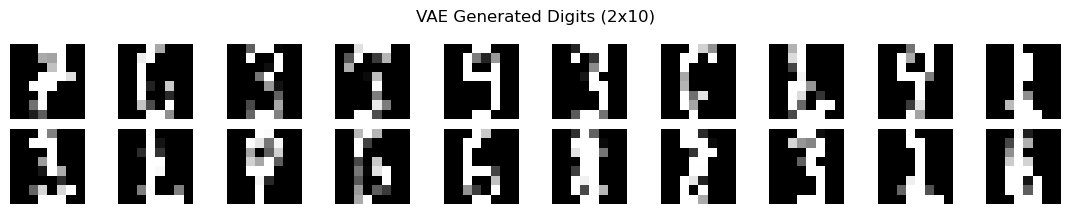

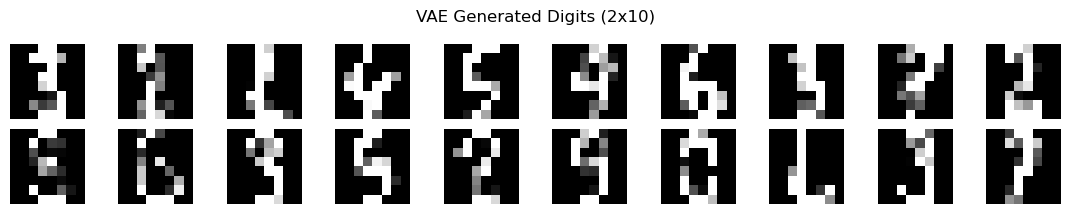

In [18]:
def show_generated_samples(model, num_samples=20, seed=0, title="VAE Samples"):
    model.eval()
    rng = np.random.RandomState(seed)
    z = torch.from_numpy(rng.randn(num_samples, model.latent_dim).astype(np.float32)).to(device)
    with torch.no_grad():
        x_gen = model.decode(z).cpu().numpy()

    H = W = 8
    rows, cols = 2, num_samples // 2
    fig, axes = plt.subplots(rows, cols, figsize=(1.1*cols, 2.2))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.clip(x_gen[i].reshape(H, W), 0, 1), cmap="gray")
        ax.axis("off")
    fig.suptitle(title, y=0.95)
    plt.tight_layout()
    plt.show()

for i in range(100):
    show_generated_samples(best_vae, num_samples=20, seed=i, title="VAE Generated Digits (2x10)")
